In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/language-translation-englishfrench/eng_-french.csv


In [2]:
train_t = pd.read_csv('/kaggle/input/language-translation-englishfrench/eng_-french.csv')

df = train_t[0:100000]

import re
english = []
french = []
for i in df['English words/sentences']:
    text = i.lower()
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(' +',' ',text)
    text = text[:-1]
    english.append(text)

for j in df['French words/sentences']:
    ftext =  j.lower()
    ftext = (re.sub("[^a-zA-Z' àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ]",' ',ftext))
    ftext = re.sub(' +',' ',ftext)
    ftext = ftext[:-1]
    french.append("start_ " + ftext + " _end")
    
cleaned_data = pd.DataFrame({'english':english,'french':french})

english_words = []
french_words = []

for i in cleaned_data['english']:
    english_words.append(len(i.split()))

for j in cleaned_data['french']:
    french_words.append(len(j.split()))

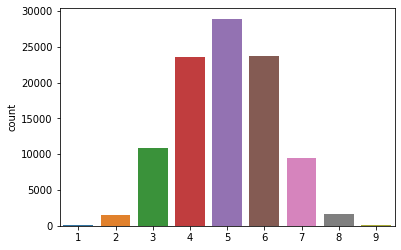

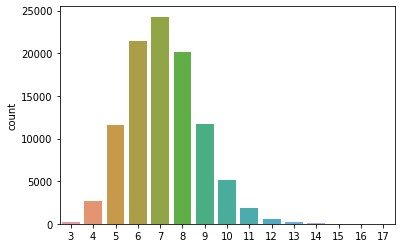

In [3]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.countplot(english_words)
plt.show()

sn.countplot(x = french_words)
plt.show()

In [4]:
max_len_english = max(english_words)
max_len_french = max(french_words)

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_data['english'],cleaned_data['french'],test_size=0.1,random_state=12,shuffle=True)

In [5]:
from keras.preprocessing.text import Tokenizer
x_tokens = Tokenizer()
x_tokens.fit_on_texts(x_tr)

x_tr = x_tokens.texts_to_sequences(x_tr)
x_val = x_tokens.texts_to_sequences(x_val)

from keras.preprocessing.sequence import pad_sequences
x_tr = pad_sequences(x_tr,maxlen = max_len_english,padding = 'post')
x_val = pad_sequences(x_val,maxlen = max_len_english,padding = 'post')

# +1 for padding 
x_voc_size   =  len(x_tokens.word_index) +1

# y data
from keras.preprocessing.text import Tokenizer
y_tokens = Tokenizer()
y_tokens.fit_on_texts(y_tr)

y_tr = y_tokens.texts_to_sequences(y_tr)
y_val = y_tokens.texts_to_sequences(y_val)

from keras.preprocessing.sequence import pad_sequences
y_tr = pad_sequences(y_tr,maxlen = max_len_french,padding = 'post')
y_val = pad_sequences(y_val,maxlen = max_len_french,padding = 'post')

# +1 for padding 
y_voc_size   =  len(y_tokens.word_index) +1

Using TensorFlow backend.


In [6]:
!pip install attention

In [7]:
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
K.clear_session()

latent_dim = 300

encoder_inputs = Input(shape=(max_len_english,))

enc_emb =  Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs, forward_h3, forward_c3, backward_h3, backward_c3= encoder_lstm3(encoder_output2)

state_h = Concatenate()([forward_h3,backward_h3])
state_c = Concatenate()([forward_c3,backward_c3])

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(600, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

attn_layer = Attention()

attn_out = attn_layer([decoder_outputs, encoder_outputs])

print(attn_out.shape, encoder_outputs.shape, decoder_outputs.shape)

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([attn_out, decoder_outputs])

decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_out = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_out)

model.summary()

(None, None, 600) (None, 9, 600) (None, None, 600)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 300)       2508600     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 9, 600), (No 1442400     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 9, 600), (No 2162400     bidirectional[0][0]              
___________________________________________

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min')

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=15,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 90000 samples, validate on 10000 samples
Epoch 1/15
90000/90000 [==============================] - 136s 2ms/sample - loss: 1.9148 - accuracy: 0.7137 - val_loss: 1.4637 - val_accuracy: 0.7509
Epoch 2/15
90000/90000 [==============================] - 121s 1ms/sample - loss: 1.3061 - accuracy: 0.7712 - val_loss: 1.1796 - val_accuracy: 0.7844
Epoch 3/15
90000/90000 [==============================] - 121s 1ms/sample - loss: 1.0432 - accuracy: 0.8003 - val_loss: 1.0190 - val_accuracy: 0.8077
Epoch 4/15
90000/90000 [==============================] - 122s 1ms/sample - loss: 0.8492 - accuracy: 0.8246 - val_loss: 0.8927 - val_accuracy: 0.8262
Epoch 5/15
90000/90000 [==============================] - 121s 1ms/sample - loss: 0.6837 - accuracy: 0.8491 - val_loss: 0.7891 - val_accuracy: 0.8429
Epoch 6/15
90000/90000 [==============================] - 121s 1ms/sample - loss: 0.5420 - accuracy: 0.8735 - val_loss: 0.7075 - val_accuracy: 0.8589
Epoch 7/15
90000/90000 [==========================

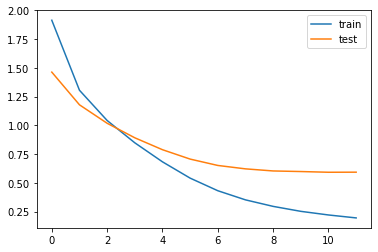

In [9]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
reverse_target_word_index=y_tokens.index_word
reverse_source_word_index=x_tokens.index_word
target_word_index=y_tokens.word_index

In [11]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(600,))
decoder_state_input_c = Input(shape=(600,))
decoder_hidden_state_input = Input(shape=(max_len_english,600))

dec_emb2= dec_emb_layer(decoder_inputs) 

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

decoder_inf_concat = Concatenate(axis=-1, name='concat')([attn_out_inf, decoder_outputs2])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [12]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_len_french-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        e_h, e_c = h, c

    return decoded_sentence

In [13]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString


for i in range(11,20):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_english)))
  print("\n")

Review: jackson is my family name 
Original summary: jackson est mon nom de famille 
Predicted summary:  l'huile est mon père de famille


Review: i really like you 
Original summary: tu me plais vraiment 
Predicted summary:  je t'aime vraiment


Review: don t tell anybody 
Original summary: ne le dis à personne 
Predicted summary:  ne le contez à personne


Review: i ve been there a lot 
Original summary: j'y ai beaucoup été 
Predicted summary:  j'y suis beaucoup allé


Review: i like skiing very much 
Original summary: j'adore le ski 
Predicted summary:  j'aime beaucoup la ski


Review: are you sure it was tom 
Original summary: êtes vous sûr que c'était tom 
Predicted summary:  es tu sûr que c'était tom


Review: you re all very nice people 
Original summary: vous êtes tous des gens très sympathiques 
Predicted summary:  vous êtes toutes très en colère très longtemps


Review: i knew they were coming 
Original summary: je savais qu'elles venaient 
Predicted summary:  je savais qu'il